In [1]:
import xarray as xr
import os
import pandas as pd
import cmweather
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dask_jobqueue import SLURMCluster
from distributed import Client, progress
from scipy.interpolate import interp1d

In [2]:
cluster = SLURMCluster(cores=36, processes=6, memory='128GB', walltime='6:00:00')
cluster.scale(12)

In [3]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.221.70.6:8787/status,
Dashboard: http://140.221.70.6:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.221.70.6:43821,Workers: 0
Dashboard: http://140.221.70.6:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Data integrity check

In [9]:
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
for fi in listy:
    try:
        ds = xr.open_dataset(fi)
        ds.close()
    except RuntimeError:
        print("Removing %s" % fi)
        os.remove(fi)
        

## Data resampling

In [20]:
i = 0
dest_dir = '/lcrc/group/earthscience/rjackson/kazrcloudsat/hourly_ave/'
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
futures = client.map(resample_to_hour, listy)
progress(futures)


VBox()

In [29]:
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
ds = xr.open_dataset(listy[0])

In [15]:
def resample_to_hour(file_name):
    try:
        ds = xr.open_dataset(file_name)
        base, path = os.path.split(file_name)
        ds['reflectivity_best_estimate'] = ds['reflectivity_best_estimate'].where(ds['reflectivity_clutter_flag'] == 1, drop=False)
        ds['mean_doppler_velocity'] = ds['mean_doppler_velocity'].where(ds['reflectivity_clutter_flag'] == 1, drop=False)
        ds['spectral_width'] = ds['spectral_width'].where(ds['spectral_width'] == 1, drop=False)
        ds = ds.resample(time='1h').mean()
        out_path = os.path.join(dest_dir, path)
        ds.to_netcdf(out_path)
        ds.close()
    except RuntimeError:
        return

In [9]:
nsa_data_path = '/lcrc/group/earthscience/NSA/Johannes-ck-new.dat'
nsa_cluster = pd.read_csv(nsa_data_path, index_col=["time"], parse_dates=True).to_xarray()

In [36]:
plt.plot(e3sm_avgs.time.dt.values)

AttributeError: 'DatetimeAccessor' object has no attribute 'values'

In [2]:
e3sm_columns = xr.open_dataset('subcols.nc')
e3sm_avgs = xr.open_dataset('E3SM_NSA_col_hourly_dump.nc')

In [10]:
dest_dir = '/lcrc/group/earthscience/rjackson/kazrcloudsat/hourly_ave/*.nc'
file_list = glob(dest_dir)
ds = xr.open_dataset(file_list[0])
heights = ds.height.values
ds.close()
refls = []
clusters = []
vels = []
for fi in file_list:
    ds = xr.open_dataset(fi)
    heights = ds.height.values
    refls.append(ds.reflectivity_best_estimate.values)
    vels.append(ds.mean_doppler_velocity.values)
    try:
        clusters.append(np.array([nsa_cluster["class"].sel(time=ds.time.values[0]).values]))
    except KeyError:
        clusters.append(np.array([np.nan]))
refls = np.concatenate(refls, axis=0)
vels = np.concatenate(vels, axis=0)
clusters = np.concatenate(clusters, axis=0)


In [6]:
refl_bins = np.linspace(-50, 20, 40)
hists_ref = np.zeros((4, len(heights), len(refl_bins) - 1))
vel_bins = np.linspace(-2, 2, 40)
hists_vel = np.zeros((4, len(heights), len(vel_bins) - 1))
medians_ref = np.zeros((4, len(heights)))
medians_vel = np.zeros((4, len(heights)))  

for c in range(4):
    which_inds = np.argwhere(clusters == c+1)
    for h in range(len(heights)):
        hist, bins = np.histogram(refls[which_inds, h], bins=refl_bins)
        hists_ref[c, h] = hist / np.sum(hist)
        medians_ref[c, h] = np.nanpercentile(refls[which_inds, h], 50)
        hist, bins = np.histogram(vels[which_inds, h], bins=vel_bins)
        hists_vel[c, h] = hist / np.sum(hist)
        medians_vel[c, h] = np.nanpercentile(vels[which_inds, h], 50)
hists_ref = np.where(hists_ref > 0, hists_ref, np.nan)
hists_vel = np.where(hists_vel > 0, hists_vel, np.nan)

/tmp/ipykernel_8310/4269008533.py:15: RuntimeWarning: divide by zero encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)
/tmp/ipykernel_8310/4269008533.py:15: RuntimeWarning: invalid value encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)
/tmp/ipykernel_8310/4269008533.py:12: RuntimeWarning: divide by zero encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/tmp/ipykernel_8310/4269008533.py:12: RuntimeWarning: invalid value encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


In [3]:
Rd = 287.057
g0 = 9.80665
e3sm_avgs["P"] = e3sm_avgs["hyam"] * e3sm_avgs["P0"] + e3sm_avgs["hybm"] * e3sm_avgs["PS"]
e3sm_avgs["heights"] = Rd * e3sm_avgs["T"] * (-np.log(e3sm_avgs["P"]) + np.log(e3sm_avgs["PS"])) / g0 * 1e-3
rho = e3sm_avgs["P"] / (Rd * e3sm_avgs["T"])
content_conversion_factor = rho * 1e3
e3sm_avgs["CLOUD_FILTER"] = e3sm_avgs["CLOUD"].where(e3sm_avgs["CLOUD"] > 0.01)
LWC_array = e3sm_avgs["CLDLIQ"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
IWC_array = e3sm_avgs["CLDICE"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
LWC_array += e3sm_avgs["RAINQM"].values * content_conversion_factor
IWC_array += e3sm_avgs["SNOWQM"].values * content_conversion_factor
LWC_array = np.where(np.isfinite(LWC_array), LWC_array, 0)
IWC_array = np.where(np.isfinite(IWC_array), IWC_array, 0)
Ze = e3sm_columns["sub_col_Ze_tot"].mean(dim='subcolumn', skipna=True)

In [12]:
e3sm_avgs["class"] = nsa_cluster["class"].sortby('time').convert_calendar('noleap').reindex(time=e3sm_avgs.time, method='nearest')

In [73]:
clear_pct = 1 - e3sm_avgs["CLOUD"].values
height = e3sm_avgs["heights"].values
LWC_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
IWC_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
clear_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
Ze_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
for i in range(LWC_array.shape[0]):
    if i % 100 == 0:
        print('%d/%d' % (i, LWC_array.shape[0]))
    LWC = interp1d(height[i, :], LWC_array[i, :], fill_value="extrapolate")
    IWC = interp1d(height[i, :], IWC_array[i, :], fill_value="extrapolate")
    clear = interp1d(height[i, :], clear_pct[i, :], fill_value="extrapolate")
    Zei = interp1d(height[i, :], Ze[i, :], fill_value="extrapolate")
    Ze_array_interp[i, :] = Zei(heights / 1e3)
    LWC_array_interp[i, :] = LWC(heights / 1e3)
    IWC_array_interp[i, :] = IWC(heights / 1e3)
    clear_array_interp[i, :] = clear(heights / 1e3)

0/18000
100/18000
200/18000
300/18000
400/18000
500/18000
600/18000
700/18000
800/18000
900/18000
1000/18000
1100/18000
1200/18000
1300/18000
1400/18000
1500/18000
1600/18000
1700/18000
1800/18000
1900/18000
2000/18000
2100/18000
2200/18000
2300/18000
2400/18000
2500/18000
2600/18000
2700/18000
2800/18000
2900/18000
3000/18000
3100/18000
3200/18000
3300/18000
3400/18000
3500/18000
3600/18000
3700/18000
3800/18000
3900/18000
4000/18000
4100/18000
4200/18000
4300/18000
4400/18000
4500/18000
4600/18000
4700/18000
4800/18000
4900/18000
5000/18000
5100/18000
5200/18000
5300/18000
5400/18000
5500/18000
5600/18000
5700/18000
5800/18000
5900/18000
6000/18000
6100/18000
6200/18000
6300/18000
6400/18000
6500/18000
6600/18000
6700/18000
6800/18000
6900/18000
7000/18000
7100/18000
7200/18000
7300/18000
7400/18000
7500/18000
7600/18000
7700/18000
7800/18000
7900/18000
8000/18000
8100/18000
8200/18000
8300/18000
8400/18000
8500/18000
8600/18000
8700/18000
8800/18000
8900/18000
9000/18000
9100/18000


/tmp/ipykernel_8310/1644181664.py:6: RuntimeWarning: Mean of empty slice
  Ze_clusters = np.nanmean(Ze_array_interp[e3sm_avgs["class"].values == i + 1, :], axis=0)


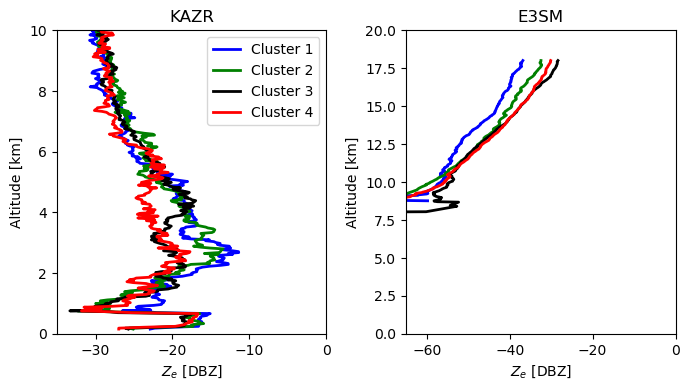

In [70]:
x_ref, y = np.meshgrid((refl_bins[:-1] + refl_bins[1:]) / 2., heights)
x_vel, y = np.meshgrid((vel_bins[:-1] + vel_bins[1:]) / 2., heights)
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
colors = ['b', 'g', 'k', 'r']
for i in range(4):
    Ze_clusters = np.nanmean(Ze_array_interp[e3sm_avgs["class"].values == i + 1, :], axis=0)
    ax[0].set_xlabel("$Z_{e}$ [DBZ]")
    ax[0].set_ylabel("Altitude [km]")
    ax[0].plot(medians_ref[i], heights / 1e3, linewidth=2, color=colors[i], label="Cluster %d" % (i + 1))
    ax[0].set_title("KAZR")
    ax[0].set_xlim([-35, 0]) 
    ax[0].set_ylim([0, 10])
    ax[1].set_xlabel("$Z_{e}$ [DBZ]")
    ax[1].set_ylabel("Altitude [km]")
    ax[1].plot(Ze_clusters, heights / 1e3, linewidth=2, color=colors[i], label="Cluster %d" % (i + 1))
    ax[1].set_title("E3SM")
    ax[1].set_xlim([-65, 0]) 
    ax[1].set_ylim([0, 20])
ax[0].legend()  
fig.tight_layout()
fig.savefig('KAZR_mean_profiles.png', dpi=300, bbox_inches='tight')

In [6]:
colors = ['b', 'g', 'k', 'r']


<xarray.Dataset>
Dimensions:       (time: 18000, ilev: 73, lev: 72, nbnd: 2)
Coordinates:
  * ilev          (ilev) float64 0.1 0.1477 0.218 0.3219 ... 990.5 997.0 1e+03
  * lev           (lev) float64 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * time          (time) object 2004-12-27 00:00:00 ... 2007-01-15 23:00:00
Dimensions without coordinates: nbnd
Data variables: (12/43)
    P0            (time) float64 ...
    hyai          (time, ilev) float64 ...
    hyam          (time, lev) float64 ...
    hybi          (time, ilev) float64 ...
    hybm          (time, lev) float64 ...
    time_bnds     (time, nbnd) object ...
    ...            ...
    lon           (time) float64 ...
    mu            (time, lev) float32 ...
    P             (time, lev) float64 12.38 18.28 26.99 ... 9.966e+04 1.001e+05
    heights       (time, lev) float64 63.35 62.3 60.4 ... 0.1023 0.04621 0.01112
    PS            (time) float32 9.97e+04 9.979e+04 ... 1.003e+05 1.003e+05
    CLOUD_FILTER  (time, lev) float32 nan nan nan nan ... 1.0 1.0 0.9999 0.9993
Attributes: (12/18)
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         c16b21f931
    product:           model-output
    realm:             atmos
    case:              v2_CTL.ne30pg2_nudging2004-2014
    ...                ...
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ca...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  hour_1
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

In [22]:
height = e3sm_avgs["heights"].values
ARRAIN_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
ARSNOW_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
AREI_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
AREL_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
ARRAIN_array = e3sm_avgs["ADRAIN"] / 2. * 1e6
ARSNOW_array = e3sm_avgs["ADSNOW"] / 2. * 1e6
AREI_array = e3sm_avgs["AREI"] 
AREL_array = e3sm_avgs["AREL"]
NUMICE_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMLIQ_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMRAI_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMSNO_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMICE_array = e3sm_avgs["NUMICE"]
NUMLIQ_array = e3sm_avgs["NUMLIQ"]
NUMRAI_array = e3sm_avgs["NUMRAI"]
NUMSNO_array = e3sm_avgs["NUMSNO"]

for i in range(LWC_array.shape[0]):
    if i % 100 == 0:
        print('%d/%d' % (i, LWC_array.shape[0]))
    ARRAIN = interp1d(height[i, :], ARRAIN_array[i, :], fill_value="extrapolate")
    ARSNOW = interp1d(height[i, :], ARSNOW_array[i, :], fill_value="extrapolate")
    NUMRAI = interp1d(height[i, :], NUMRAI_array[i, :], fill_value="extrapolate")
    NUMSNO = interp1d(height[i, :], NUMSNO_array[i, :], fill_value="extrapolate")
    NUMICE = interp1d(height[i, :], NUMICE_array[i, :], fill_value="extrapolate")
    NUMLIQ = interp1d(height[i, :], NUMLIQ_array[i, :], fill_value="extrapolate")
    AREI = interp1d(height[i, :], AREI_array[i, :], fill_value="extrapolate")
    ARED = interp1d(height[i, :], AREL_array[i, :], fill_value="extrapolate")
    ARRAIN_array_interp[i, :] = ARRAIN(heights / 1e3)
    ARSNOW_array_interp[i, :] = ARSNOW(heights / 1e3)
    NUMICE_array_interp[i, :] = NUMICE(heights / 1e3)
    NUMLIQ_array_interp[i, :] = NUMLIQ(heights / 1e3)
    NUMRAI_array_interp[i, :] = NUMRAI(heights / 1e3)
    NUMSNO_array_interp[i, :] = NUMSNO(heights / 1e3)
    AREI_array_interp[i, :] = AREI(heights / 1e3)
    AREL_array_interp[i, :] = ARED(heights / 1e3)

0/18000
100/18000
200/18000
300/18000
400/18000
500/18000
600/18000
700/18000
800/18000
900/18000
1000/18000
1100/18000
1200/18000
1300/18000
1400/18000
1500/18000
1600/18000
1700/18000
1800/18000
1900/18000
2000/18000
2100/18000
2200/18000
2300/18000
2400/18000
2500/18000
2600/18000
2700/18000
2800/18000
2900/18000
3000/18000
3100/18000
3200/18000
3300/18000
3400/18000
3500/18000
3600/18000
3700/18000
3800/18000
3900/18000
4000/18000
4100/18000
4200/18000
4300/18000
4400/18000
4500/18000
4600/18000
4700/18000
4800/18000
4900/18000
5000/18000
5100/18000
5200/18000
5300/18000
5400/18000
5500/18000
5600/18000
5700/18000
5800/18000
5900/18000
6000/18000
6100/18000
6200/18000
6300/18000
6400/18000
6500/18000
6600/18000
6700/18000
6800/18000
6900/18000
7000/18000
7100/18000
7200/18000
7300/18000
7400/18000
7500/18000
7600/18000
7700/18000
7800/18000
7900/18000
8000/18000
8100/18000
8200/18000
8300/18000
8400/18000
8500/18000
8600/18000
8700/18000
8800/18000
8900/18000
9000/18000
9100/18000


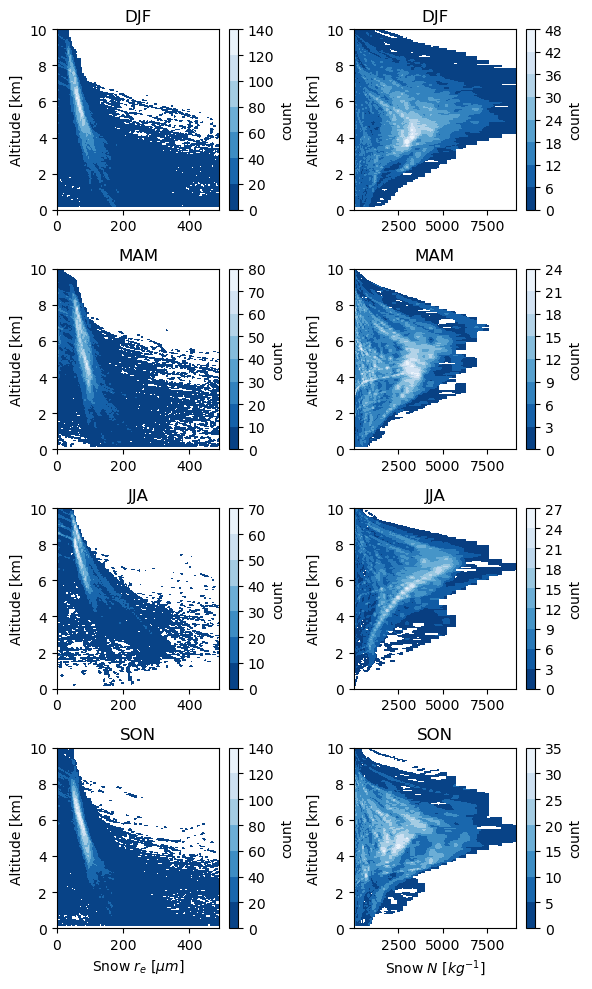

In [93]:
rei_bins = np.arange(0, 500, 5)
num_bins = np.logspace(0, 4, 100)
fig, ax = plt.subplots(4, 2, figsize=(6, 10))
ARSNOW_array_interp = np.where(ARSNOW_array_interp > 0, ARSNOW_array_interp, np.nan)
NUMSNO_array_interp = np.where(NUMSNO_array_interp > 0, NUMSNO_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(ARSNOW_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMSNO_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Snow $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Snow $N$ [$kg^{-1}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Snow_microphysics.png', bbox_inches='tight')

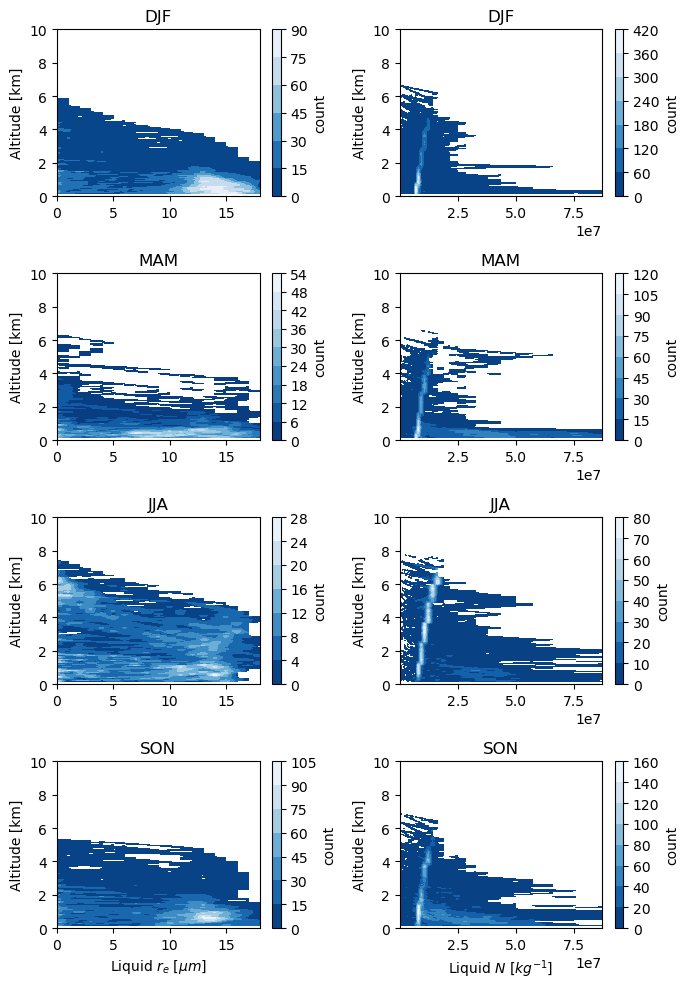

In [28]:
rei_bins = np.arange(0, 20, 1)
num_bins = np.logspace(2, 8, 100)
fig, ax = plt.subplots(4, 2, figsize=(7, 10))
AREL_array_interp = np.where(AREL_array_interp > 0, AREL_array_interp, np.nan)
NUMLIQ_array_interp = np.where(NUMLIQ_array_interp > 0, NUMLIQ_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(AREL_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMLIQ_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Liquid $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Liquid $N$ [$kg^{-1}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Liquid_microphysics.png', bbox_inches='tight')

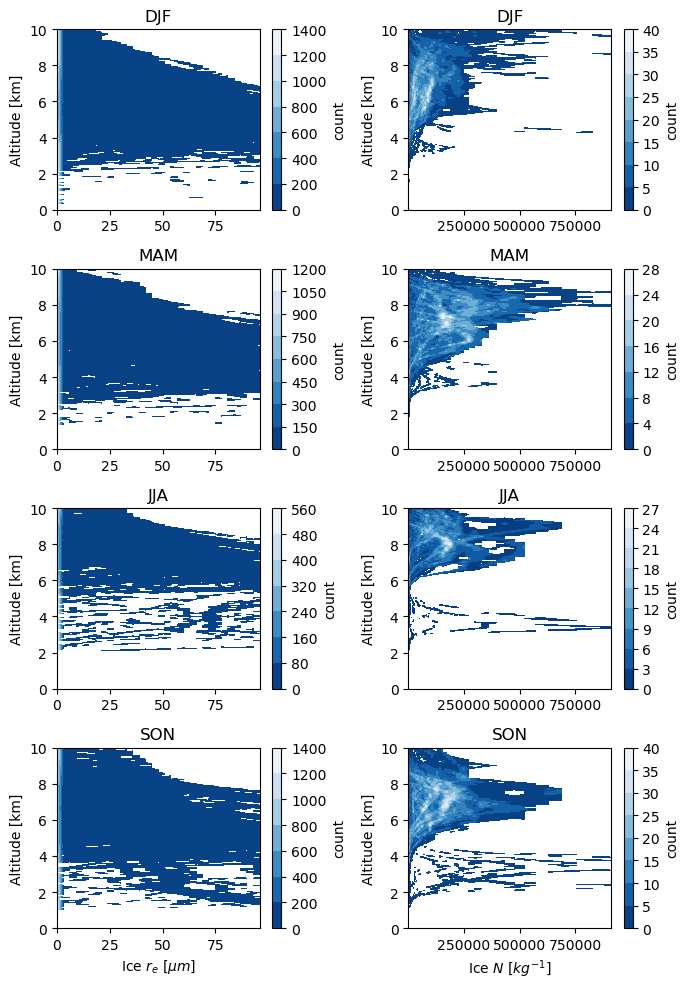

In [26]:
rei_bins = np.arange(0, 100, 3)
num_bins = np.logspace(2, 6, 100)
fig, ax = plt.subplots(4, 2, figsize=(7, 10))
AREIL_array_interp = np.where(AREI_array_interp > 0, AREL_array_interp, np.nan)
NUMICE_array_interp = np.where(NUMICE_array_interp > 0, NUMICE_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(AREI_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMICE_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Ice $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Ice $N$ [$kg^{-1}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Ice_microphysics.png', bbox_inches='tight')

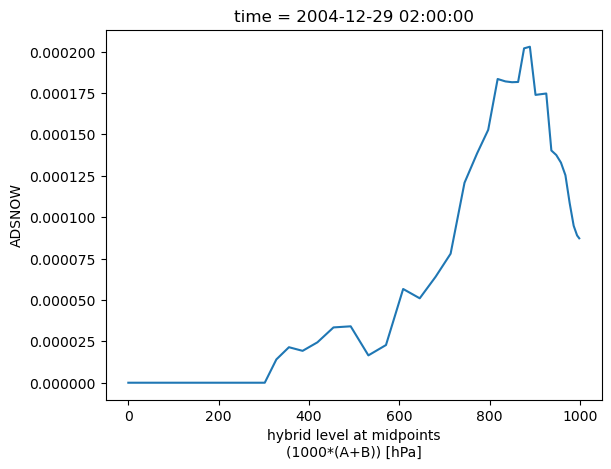

In [39]:
rei_bins = np.arange(0, 500, 5)
num_bins = np.logspace(0, 4, 100)
fig, ax = plt.subplots(4, 2, figsize=(6, 10))
ARSNOW_array_interp = np.where(ARSNOW_array_interp > 0, ARSNOW_array_interp, np.nan)
NUMSNO_array_interp = np.where(NUMSNO_array_interp > 0, NUMSNO_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(ARSNOW_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMSNO_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Snow $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Snow $N$ [$kg^{-1}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Snow_microphysics.png', bbox_inches='tight')

In [72]:
NUMSNO_array

<xarray.DataArray 'NUMSNO' (time: 18000, lev: 72)>
array([[1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 9.961126e-01,
        1.027731e+00, 1.042116e+00],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 9.931056e-01,
        9.354649e-01, 9.086934e-01],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 1.405397e+00,
        1.349213e+00, 1.323021e+00],
       ...,
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 4.989690e+01,
        5.052849e+01, 5.078683e+01],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 4.687043e+01,
        4.753429e+01, 4.781018e+01],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 4.448421e+01,
        4.502760e+01, 4.524813e+01]], dtype=float32)
Coordinates:
  * lev      (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
  * time     (time) object 2004-12-27 00:00:00 ... 2007-01-15 23:00:00
Attributes:
    mdims:         1
    units:         1/kg
    mixing_ratio:  wet
    long_name:     Grid box averaged snow number
    cell_methods:  time: mean
    basename:      NUMSNO